## AAUtoSig Markdown
This document is a runthrough of our autoencoder model.
Firstly we initialise our installed packages

In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.spatial as sp
import random

from random import sample
from itertools import permutations
from functions import simulate_counts, plotsigs, cosine_perm

## Initialise the autoencoder
The following block creates a class to initialize a one-hidden-layer linear autoencoder, and a method for traning the one such model.

In [2]:
class NMFAE(torch.nn.Module):
    def __init__(self, dim1):
    
        super().__init__()

        # Building an linear encoder
        # 96 => dim1
        self.enc1 = torch.nn.Linear(1536, dim1, bias = False)
          
        # Building an linear decoder 
        # dim1 ==> 96
        self.dec1 = torch.nn.Linear(dim1, 1536, bias = False)
            

    def forward(self, x):
        x = self.enc1(x)
        x = self.dec1(x)
        return x
        
    # Model Initialization
                                
def train_NMFAE(epochs, model, x_train, loss_function, optimizer, batch_size):
    
    #turn the training data into a tensor
    x_train_tensor = torch.tensor(x_train.values, 
                              dtype = torch.float32)
    
    #this is what loads makes the updates batch-wise insted of the full data matrix
    trainloader = torch.utils.data.DataLoader(x_train_tensor, 
                                              batch_size=batch_size, 
                                              shuffle=True)
    
    for _ in range(epochs):
        model.train() #set model in traning mode (alternative model.eval())
        
        for data in trainloader:
          # Output of Autoencoder
          reconstructed = model(data)
            
          # Calculating the loss function
          loss = loss_function(reconstructed, data)


          optimizer.zero_grad() #clear old gradients
          loss.backward() #backpropagation
          optimizer.step() #update params
        #constrain the weights of the decoding layer to be non-negative  
        with torch.no_grad():
            for p in model.dec1.weight:
                p.clamp_(min = 0)
        
    return(model)

## Application
Now we can use our autoencoder on some simulated data

In [3]:
nsigs = 5

np.random.seed(20)
random.seed(20)
mf_df, true_sigs,_ = simulate_counts(5,3000, pentanucelotide = True)
penta = mf_df.index
mutation = [p[3:6] for p in penta]

X = mf_df.transpose()

#80/20 train/validation split
x_train = X.sample(frac=0.8)
x_val = X.drop(x_train.index)

#choosing the 'true' number of signatures
model = NMFAE(dim1 = nsigs)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss(reduction='mean')

# Using an Adam Optimizer with lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(),
                            lr = 1e-3)
                            
train_NMFAE(epochs = 500, 
            model = model, 
            x_train = x_train, 
            loss_function = loss_function, 
            optimizer = optimizer,
            batch_size=16)


#the weights of the decoding layer (dec1) is where we find the signatures.
sigs = model.dec1.weight.data    
sigs = pd.DataFrame(sigs.numpy()) 

In [4]:
tri = [p[1:8] for p in penta]
sigs['Mutation type'] = mutation
sigs['Trinucleotide'] = tri
sigs['Pentanucleotide'] = penta
sigs

sigs96 = pd.DataFrame(sigs.groupby('Trinucleotide').sum())
sigs96['Mutation'] = [s[2:5] for s in sigs96.index]
sigs96 = sigs96.sort_values('Mutation')
trinucleotide = sigs96.index
mutation = sigs96['Mutation']
sigs96 = sigs96.drop('Mutation', axis = 1)



true_sigs['Trinucleotide'] = tri
true_sigs96 = pd.DataFrame(true_sigs.groupby('Trinucleotide').sum())
true_sigs96['Mutation'] = [s[2:5] for s in true_sigs96.index]
true_sigs96 = true_sigs96.sort_values('Mutation')
true_sigs96 = true_sigs96.drop('Mutation', axis = 1)

perm = cosine_perm(sigs96.T,true_sigs96.T)
sigs96 = sigs96[perm[1]]

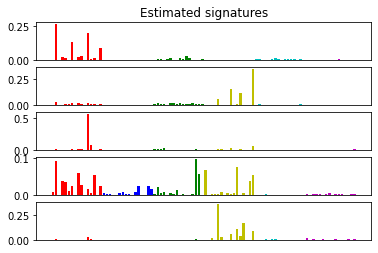

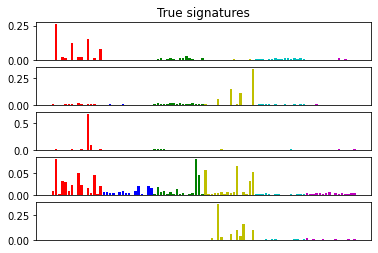

In [5]:
#plot the results
plotsigs(trinucleotide, mutation, sigs96.to_numpy(), nsigs, "Estimated signatures")  
plotsigs(trinucleotide, mutation, true_sigs96.to_numpy(), nsigs, "True signatures")  